# Máy học nâng cao - Lab 06
# Họ tên: Nguyễn Phú Thành - MSSV: 18110014

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalAveragePooling1D, Conv1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/AML/main/lab-04/spam_detection.csv")
df.head()

,Text,Label,y
0,"Go until jurong point, crazy.. Available only ...",ham,0
1,Ok lar... Joking wif u oni...,ham,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,1
3,U dun say so early hor... U c already then say...,ham,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,0


In [3]:
nltk.download('punkt')
texts = df["Text"].to_list()
texts = [text.lower() for text in texts]
tokenized_texts = [nltk.tokenize.word_tokenize(text) for text in texts]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-11-17 04:45:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-11-17 04:45:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-17 04:45:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

# 1. Hãy dùng bộ FastText 300d để làm embedding cho model

In [5]:
def load_word_embeddings(fname):
    vocab, matrix = [], []
    with open(fname, mode = 'r', encoding = 'utf-8', errors = 'ignore', newline = '\n') as fin:
        for line in fin:
            tokens = line.rstrip().split(' ')
            vocab.append(tokens[0])
            matrix.append(list(map(float, tokens[1:])))
    return vocab, np.asarray(matrix)

In [6]:
vocab, matrix = load_word_embeddings("glove.6B.300d.txt")
word_to_index = {word: index + 2 for index, word in enumerate(vocab)}

In [7]:
__PADDED_INDEX__ = 0
__UNKNOWN_WORD__ = 1

In [8]:
embedding_matrix = np.pad(matrix, ((2,0),(0,0)), mode = 'constant', constant_values = 0.0)
print(embedding_matrix)

[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.04656    0.21318   -0.0074364 ...  0.0090611 -0.20989    0.053913 ]
 ...
 [ 0.075713  -0.040502   0.18345   ...  0.21838    0.30967    0.43761  ]
 [ 0.81451   -0.36221    0.31186   ...  0.075486   0.28408   -0.17559  ]
 [ 0.429191  -0.296897   0.15011   ...  0.28975    0.32618   -0.0590532]]


# 2. Hãy tìm hiểu cách dùng của convolution 1D trong keras để train mô hình dưới đây 
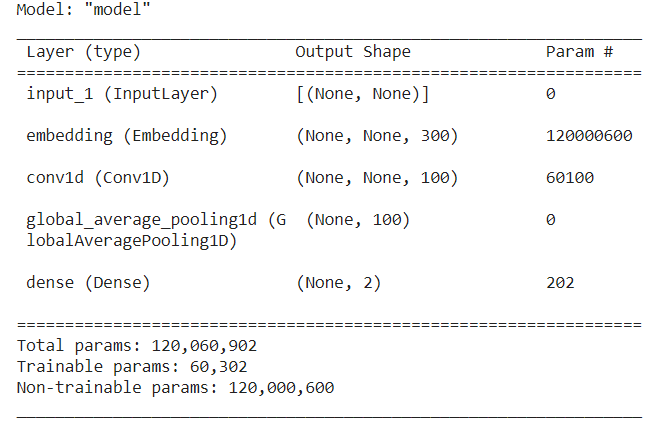
# 3. Xét 2 trường hợp trainable là True và False trong lớp embedding và đưa ra so sánh

In [9]:
X = []
for text in tokenized_texts:
    cur_text_indices = []
    for word in text:
        cur_text_indices.append(word_to_index[word]) if word in word_to_index else cur_text_indices.append(__UNKNOWN_WORD__)
    X.append(cur_text_indices)

X = tf.keras.preprocessing.sequence.pad_sequences(
    sequences = X,
    padding = 'post'
)

y = df['y'].values

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Trường hợp trainable = False trong lớp embedding

In [11]:
inputs = Input(shape = (None,))
embed = Embedding(
    input_dim = embedding_matrix.shape[0],
    output_dim = embedding_matrix.shape[1],
    embeddings_initializer = tf.keras.initializers.Constant(value = embedding_matrix),
    trainable = False,
    mask_zero = True
)(inputs)
conv_1d = Conv1D(
    filters = 100, 
    kernel_size = 2, 
    strides = 1,
    padding = "same"
)(embed)
global_avg = GlobalAveragePooling1D()(conv_1d)
dense = Dense(units = 2, activation = "softmax")(global_avg)

model = Model(inputs = inputs, outputs = dense)
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = "sparse_categorical_crossentropy",
    metrics = ("accuracy",)
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         120000600 
                                                                 
 conv1d (Conv1D)             (None, None, 100)         60100     
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 120,060,902
Trainable params: 60,302
Non-trainable params: 120,000,600
__________________________________________

In [12]:
history_1 = model.fit(
    X_train, y_train,
    epochs = 10,
    batch_size = 100,
    validation_data = (X_valid, y_valid)
)

Epoch 1/10
45/45 [==============================] - 8s 151ms/step - loss: 0.4573 - accuracy: 0.8607 - val_loss: 0.3758 - val_accuracy: 0.8520
Epoch 2/10
45/45 [==============================] - 6s 145ms/step - loss: 0.2784 - accuracy: 0.8989 - val_loss: 0.2144 - val_accuracy: 0.9390
Epoch 3/10
45/45 [==============================] - 6s 144ms/step - loss: 0.1650 - accuracy: 0.9493 - val_loss: 0.1543 - val_accuracy: 0.9480
Epoch 4/10
45/45 [==============================] - 7s 146ms/step - loss: 0.1263 - accuracy: 0.9578 - val_loss: 0.1304 - val_accuracy: 0.9552
Epoch 5/10
45/45 [==============================] - 7s 146ms/step - loss: 0.1076 - accuracy: 0.9641 - val_loss: 0.1211 - val_accuracy: 0.9570
Epoch 6/10
45/45 [==============================] - 6s 145ms/step - loss: 0.0969 - accuracy: 0.9673 - val_loss: 0.1148 - val_accuracy: 0.9587
Epoch 7/10
45/45 [==============================] - 6s 144ms/step - loss: 0.0915 - accuracy: 0.9684 - val_loss: 0.1106 - val_accuracy: 0.9623
Epoch 

## Trường hợp trainable = True trong lớp embedding

In [13]:
inputs = Input(shape = (None,))
embed = Embedding(
    input_dim = embedding_matrix.shape[0],
    output_dim = embedding_matrix.shape[1],
    embeddings_initializer = tf.keras.initializers.Constant(value = embedding_matrix),
    trainable = True,
    mask_zero = True
)(inputs)
conv_1d = Conv1D(
    filters = 100, 
    kernel_size = 2, 
    strides = 1,
    padding = "same"
)(embed)
global_avg = GlobalAveragePooling1D()(conv_1d)
dense = Dense(units = 2, activation = "softmax")(global_avg)

model = Model(inputs = inputs, outputs = dense)
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = "sparse_categorical_crossentropy",
    metrics = ("accuracy",)
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 300)         120000600 
                                                                 
 conv1d_1 (Conv1D)           (None, None, 100)         60100     
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 120,060,902
Trainable params: 120,060,902
Non-trainable params: 0
_____________________________________________

In [14]:
history_2 = model.fit(
    X_train, y_train,
    epochs = 10,
    batch_size = 100,
    validation_data = (X_valid, y_valid)
)

Epoch 1/10
45/45 [==============================] - 63s 1s/step - loss: 0.4056 - accuracy: 0.8684 - val_loss: 0.3339 - val_accuracy: 0.8520
Epoch 2/10
45/45 [==============================] - 59s 1s/step - loss: 0.2110 - accuracy: 0.9081 - val_loss: 0.1374 - val_accuracy: 0.9578
Epoch 3/10
45/45 [==============================] - 59s 1s/step - loss: 0.0857 - accuracy: 0.9731 - val_loss: 0.0860 - val_accuracy: 0.9758
Epoch 4/10
45/45 [==============================] - 59s 1s/step - loss: 0.0541 - accuracy: 0.9814 - val_loss: 0.0758 - val_accuracy: 0.9794
Epoch 5/10
45/45 [==============================] - 59s 1s/step - loss: 0.0446 - accuracy: 0.9861 - val_loss: 0.0681 - val_accuracy: 0.9803
Epoch 6/10
45/45 [==============================] - 59s 1s/step - loss: 0.0305 - accuracy: 0.9917 - val_loss: 0.0601 - val_accuracy: 0.9821
Epoch 7/10
45/45 [==============================] - 59s 1s/step - loss: 0.0247 - accuracy: 0.9930 - val_loss: 0.0582 - val_accuracy: 0.9848
Epoch 8/10
45/45 [==

## So sánh 2 trường hợp

In [15]:
def plot_history(history, n_epochs = 10):
    kwargs_axes_1 = {
        "color": 'b',
        "marker": 'o',
        "markersize": 5
    }
    kwargs_axes_2 = {
        "color": 'r',
        "marker": 'o',
        "markersize": 5
    }
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 15))
    axes[0].plot(np.arange(1, n_epochs + 1), history.history['loss'], **kwargs_axes_1, label = 'Training Loss')
    axes[0].plot(np.arange(1, n_epochs + 1), history.history['val_loss'], **kwargs_axes_2, label = 'Validation Loss')

    axes[1].plot(np.arange(1, n_epochs + 1), history.history['accuracy'], **kwargs_axes_1, label = 'Training Accuracy')
    axes[1].plot(np.arange(1, n_epochs + 1), history.history['val_accuracy'], **kwargs_axes_2, label = 'Validation Accuracy')
    
    for ax in axes.flatten():
        ax.set(xticks = np.arange(1, n_epochs + 1))
        ax.grid(True)
        ax.legend()
    axes[0].set(yticks = np.linspace(0, 1, num = 11))
    axes[1].set(yticks = np.linspace(0, 1, num = 51))
    plt.show()

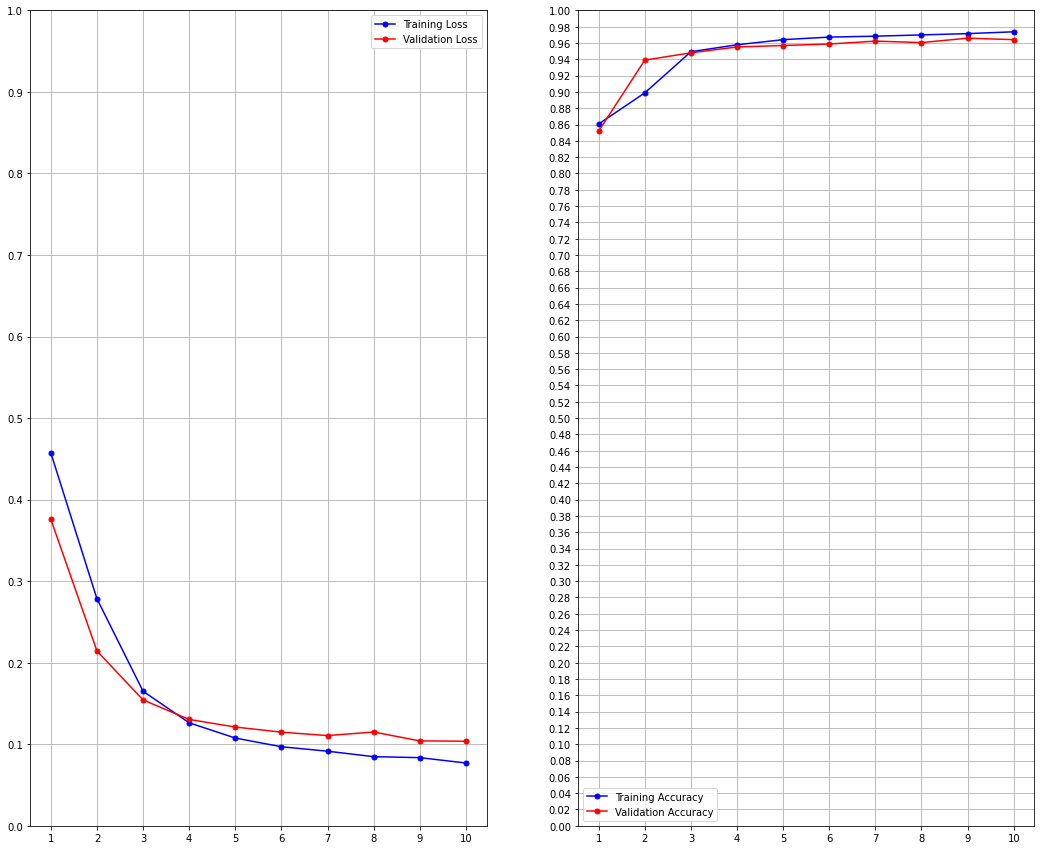

In [16]:
# TH1: Khi trainable = False
plot_history(history_1)

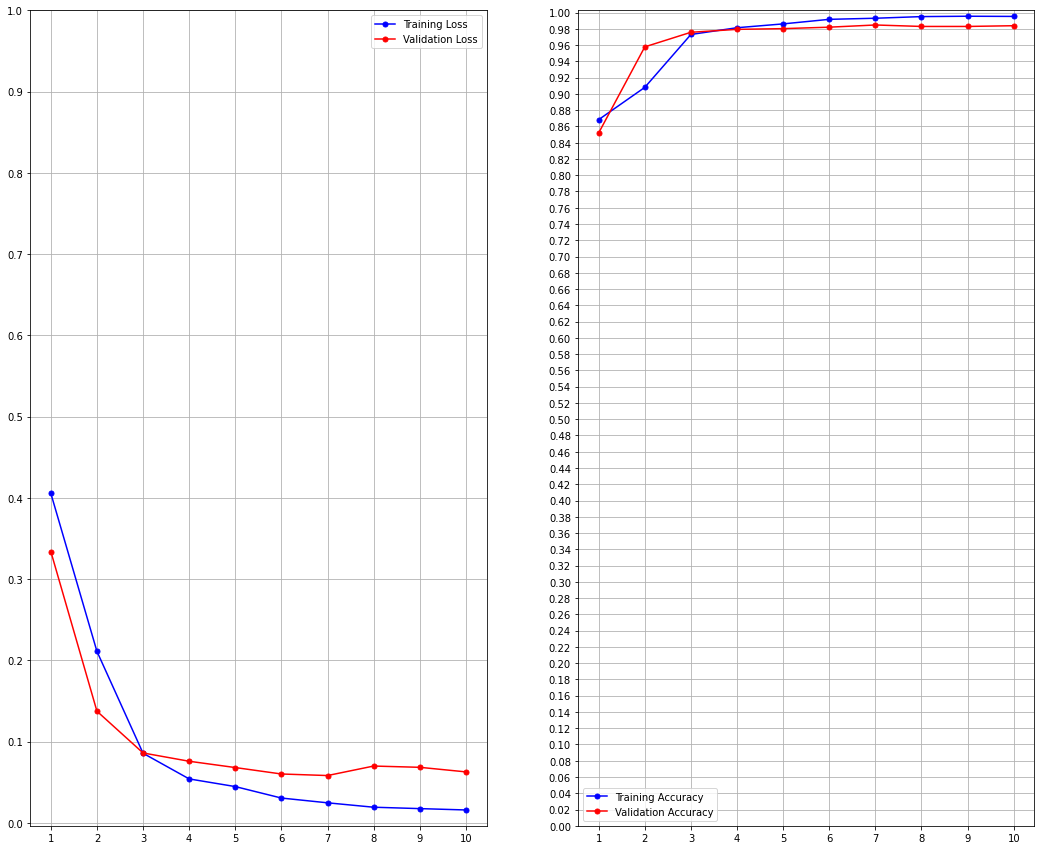

In [17]:
# TH2: Khi trainable = True
plot_history(history_2)

**So sánh:** 
Như hai biểu đồ về accuracy trong 2 trường hợp, khi trainable = False thì độ chính xác của mô hình trên tập train và tập valid đều không vượt quá 98%. Tuy nhiên khi trainable = True thì độ chính xác của mô hình trên tập train và tập valid từ epoch thứ năm trở đi đều > 98%

Mặt khác, so về biểu đồ của loss trong hai trường hợp thì khi trainable = True, mô hình có xu hướng overfit hơn là khi trainable = False (do khi trainable = True thì lớp embedding học tốt hơn cho tập train hơn là tập valid)